# Instance based attacks

This notebook demonstrates additional issues that are unique to instance-based models.

Instance-based models are popular within Machine Learning -- common examples are K-Nearest-Neighbours and the Support Vector Machine. All machine learning models (instance-based or otherwise) require access to data during the training phase. What makes instance-based models distinct is that they also require access to training data to make predictions and therefore need to store some of the training data within the model file.

As it is this model file that researchers wish to export from the TRE, this constitutes a problem.

We will illustrate this with an example.

In [1]:
import logging
import os

import pylab as plt

%matplotlib inline

logging.getLogger("matplotlib.font_manager").disabled = True

os.chdir("c:\\Users\\simonr04\\git\\GRAIMatter")
from data_preprocessing.data_interface import get_data_sklearn

logging.basicConfig(level=logging.DEBUG)

INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:ROOT PROJECT FOLDER = c:\Users\simonr04\git\GRAIMatter


Here we are using an open source dataset as we cannot show an example with data from the TRE.

In [2]:
DATASET_NAME = "mimic2-iaccd"
X, y = get_data_sklearn(DATASET_NAME)
# Choose some features (we don't need all of them)
FEATURES = ["age", "gender_num", "bmi", "day_icu_intime_num", "liver_flg", "copd_flg"]
subX = X[FEATURES].copy()

# Round bmi to an integer
subX["bmi"] = subX["bmi"].astype(int)
subX["age"] = subX["age"].astype(int)

INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:DATASET FOLDER = c:\Users\simonr04\git\GRAIMatter\data
INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:Loading mimic2-iaccd
INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:Preprocessing


## Training the model

We now train an instance-based model (a Support Verctor Machine; SVM). In this case, we are predicting whether an individual admitted to hospital died or not.

We start by splitting the data into two sets, and then training the model with one of the sets. We show the model performance via a ROC curve. This is just to show that the model is able to do something (lines above the dashed line show performance better than guessing).

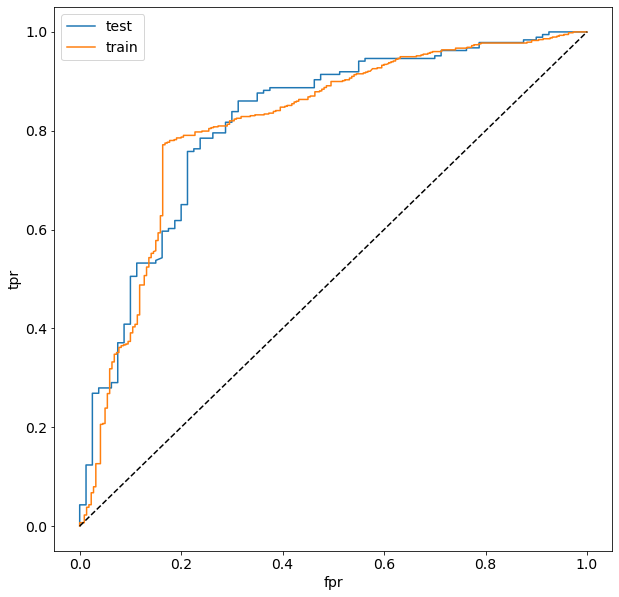

In [3]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

font = {"size": 14}
plt.rc("font", **font)
train_X, test_X, train_y, test_y = train_test_split(subX.values, y.values.flatten())
svm = SVC(probability=True, gamma=0.01)
svm.fit(train_X, train_y)
train_probs = svm.predict_proba(train_X)
test_probs = svm.predict_proba(test_X)
plt.figure(figsize=(10, 10))
fpr, tpr, _ = roc_curve(test_y, test_probs[:, 1])
plt.plot(fpr, tpr, label="test")
fpr, tpr, _ = roc_curve(train_y, train_probs[:, 1])
plt.plot(fpr, tpr, label="train")
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.plot([0, 1], [0, 1], "k--")

The python object `svm` is the model. This is what a researcher would want to save and export from the TRE.

Unfortunately, it includes _exact_ copies of some of the data examples. Details in the next cell.

In [5]:
n_support_vectors = len(svm.support_vectors_)
n_total = len(train_X)
print(
    f"In this example, the SVM has stored exact copies of {n_support_vectors} of the original data rows (out of {n_total} total rows)"
)

In this example, the SVM has stored exact copies of 441 of the original data rows (out of 798 total rows)


Without these, the SVM won't work. They are immediately accessible with access to the `svm` object. For example, here are the top 5, and the same rows from the training data for comparison:

In [6]:
NTOP = 5
for i in range(NTOP):
    sv_idx = svm.support_[i]
    sv = svm.support_vectors_[i]
    original = train_X[sv_idx, :]
    print(f"EXAMPLE {i}")
    print("\t Original:\t", original)
    print("\t Stored:\t", sv)

EXAMPLE 0
	 Original:	 [46.  1. 39.  5.  0.  0.]
	 Stored:	 [46.  1. 39.  5.  0.  0.]
EXAMPLE 1
	 Original:	 [36.  1. 26.  5.  0.  0.]
	 Stored:	 [36.  1. 26.  5.  0.  0.]
EXAMPLE 2
	 Original:	 [67.  1. 19.  4.  0.  0.]
	 Stored:	 [67.  1. 19.  4.  0.  0.]
EXAMPLE 3
	 Original:	 [55.  0. 19.  6.  0.  0.]
	 Stored:	 [55.  0. 19.  6.  0.  0.]
EXAMPLE 4
	 Original:	 [87.  0. 24.  7.  0.  0.]
	 Stored:	 [87.  0. 24.  7.  0.  0.]


It is immediately clear that exporting the model would, in effect export exact copies of some individual level data.

This is an issue with all instance-based models where an attacker has direct access to the contents of the model (or the model file). It is not an issue if the attacker is only able to query the model and not have access to its inner workings.